In [1]:
import sys
import pandas as pd
import numpy as np
import os
# import sys
import soundfile as sf
import joblib

import multiprocessing
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor


import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cycler



from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM
from keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category = DeprecationWarning)

In [2]:
# Ravdess = "D:\\Projects\\Speech Emotion Reconition\\Ravdess\\audio_speech_actors_01-24"
# Crema = "D:\\Projects\\Speech Emotion Reconition\\crema\\AudioWAV"
Tess = "D:\Projects\Speech Emotion Reconition\TESS Toronto emotional speech set data\TESS Toronto emotional speech set data"
# Savee = "D:\Projects\Speech Emotion Reconition\savee\ALL"

In [3]:
# ravdess_directory_list = os.listdir(Ravdess)

# file_emotion = []
# file_path = []
# for dir in ravdess_directory_list:
#     actor = os.listdir(os.path.join(Ravdess, dir))
#     for file in actor:
#         part = file.split('.')[0]
#         part = part.split('-')
        
    
#         file_emotion.append(int(part[2]))
#         file_path.append(os.path.join(Ravdess, dir, file))
       
    
# emotion_df = pd.DataFrame(file_emotion, columns = ['Emotions'])
# path_df = pd.DataFrame(file_path, columns = ['Path'])
# Ravdess_df = pd.concat([emotion_df, path_df], axis = 1)

# Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3: 'happy', 4: 'sad', 5: 'angry', 6:'fear', 7: 'disgust', 8: 'surprise'}, inplace = True)
# Ravdess_df.head()

In [4]:
# crema_directory_list = os.listdir(Crema)

# file_emotion = []
# file_path = []

# for file in crema_directory_list:
#     file_path.append(os.path.join(Crema, file))
#     part = file.split('_')
#     if part[2] == 'SAD':
#         file_emotion.append('sad')
#     elif part[2] == 'ANG':
#         file_emotion.append('angry')
#     elif part[2] =='DIS':
#         file_emotion.append('disgust')
#     elif part[2] =='FEA':
#         file_emotion.append('fear')
#     elif part[2] == 'HAP':
#         file_emotion.append('happy')
#     elif part[2] == 'NEU':
#         file_emotion.append('neutral')
#     else:
#         file_emotion.append('Unknown')

# emotion_df = pd.DataFrame(file_emotion, columns = ['Emotions'])

# path_df = pd.DataFrame(file_path, columns = ['Path'])
# crema_df = pd.concat([emotion_df , path_df], axis = 1)
# crema_df.head()

In [5]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(os.path.join(Tess, dir))
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        
        if part == 'ps':
            file_emotion.append('surprise')
        else:
             file_emotion.append(part)
        file_path.append(os.path.join(Tess, dir, file))

emotion_df = pd.DataFrame(file_emotion , columns = ['Emotions'])

path_df = pd.DataFrame (file_path, columns = ['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis = 1)
Tess_df.head()

,Emotions,Path
0,angry,D:\Projects\Speech Emotion Reconition\TESS Tor...
1,angry,D:\Projects\Speech Emotion Reconition\TESS Tor...
2,angry,D:\Projects\Speech Emotion Reconition\TESS Tor...
3,angry,D:\Projects\Speech Emotion Reconition\TESS Tor...
4,angry,D:\Projects\Speech Emotion Reconition\TESS Tor...


In [6]:
# savee_directory_list = os.listdir(Savee)

# file_emotion = []
# file_path = []

# for file in savee_directory_list:
#     file_path.append(os.path.join(Savee, file))
#     part = file.split('_')[1]
#     ele = part[:-6]
    
#     if ele == 'a':
#         file_emotion.append('angry')
#     elif ele=='d':
#         file_emotion.append('disgust')
#     elif ele=='f':
#         file_emotion.append('fear')
#     elif ele=='h':
#         file_emotion.append('happy')
#     elif ele=='n':
#         file_emotion.append('neutral')
#     elif ele=='sa':
#         file_emotion.append('sad')
#     else:
#         file_emotion.append('surprise')
        
# emotion_df = pd.DataFrame(file_emotion , columns = ['Emotions'])
            
# path_df = pd.DataFrame(file_path, columns = ['Path'])
# Savee_df = pd.concat([emotion_df , path_df], axis = 1)
# Savee_df.head()

In [7]:
data_path = pd.concat([Tess_df], axis = 0) #, crema_df, , Savee_df, Ravdess_df]
data_path.to_csv("data_path.csv", index = False)
data_path.head()

,Emotions,Path
0,angry,D:\Projects\Speech Emotion Reconition\TESS Tor...
1,angry,D:\Projects\Speech Emotion Reconition\TESS Tor...
2,angry,D:\Projects\Speech Emotion Reconition\TESS Tor...
3,angry,D:\Projects\Speech Emotion Reconition\TESS Tor...
4,angry,D:\Projects\Speech Emotion Reconition\TESS Tor...


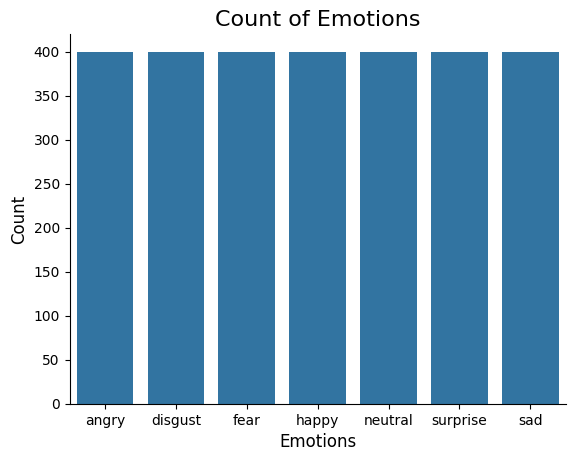

In [8]:
plt.title('Count of Emotions', size = 16)
sns.countplot(x = 'Emotions', data = data_path)
plt.ylabel('Count', size = 12)
plt.xlabel('Emotions', size = 12)
sns.despine (top = True, right= True, left = False, bottom = False)
plt.show()

In [9]:
def create_waveplot (data, sr, e):
    plt.figure(figsize = (10,3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size = 15)
    librosa.display.waveshow(data, sr=sr, color='blue') 
    plt.show()

# stft(short term fourier transform) represents signals in the time-frequency domain by computing discrete fourier transformation over short overlapping windows.
#stft function converts the data into short term fourier transform 
def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize = (12,3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size = 15)
    librosa.display.specshow(Xdb, sr=sr, x_axis = 'time', y_axis = 'hz')
    
    plt.colorbar()

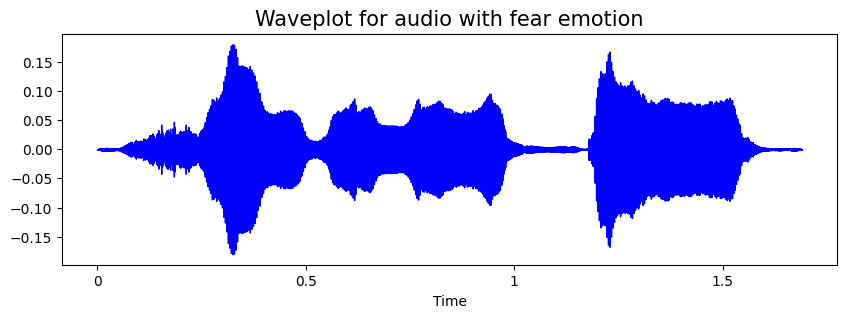

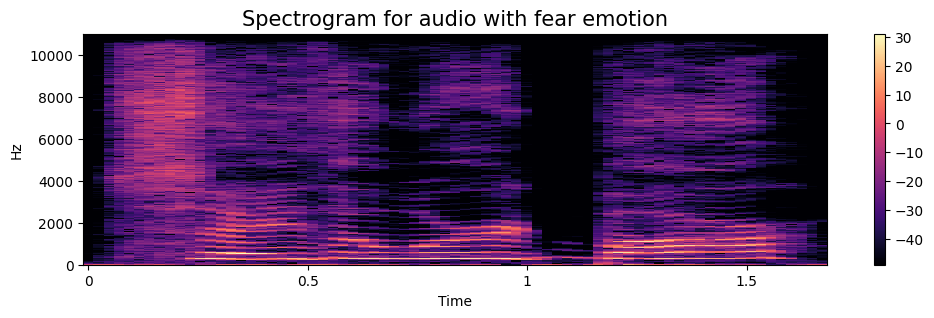

In [10]:
emotion = 'fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path) #sampling rate is the number of samples taken per second)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

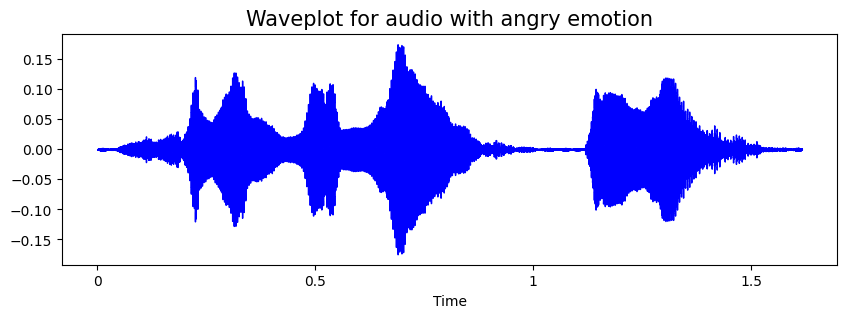

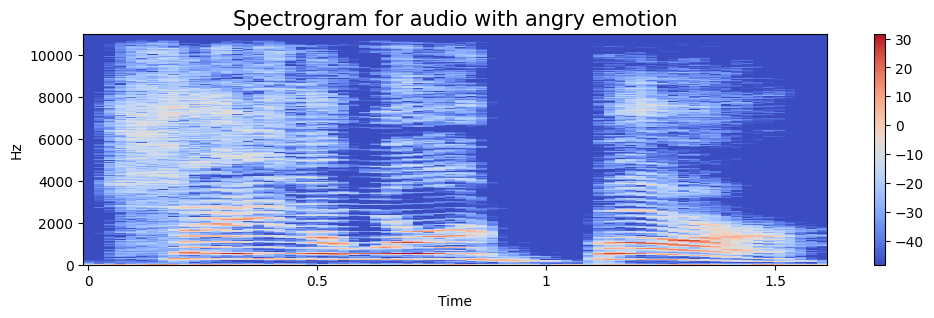

In [11]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

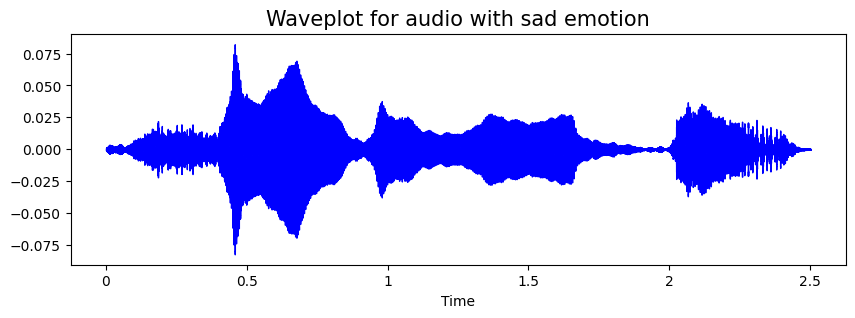

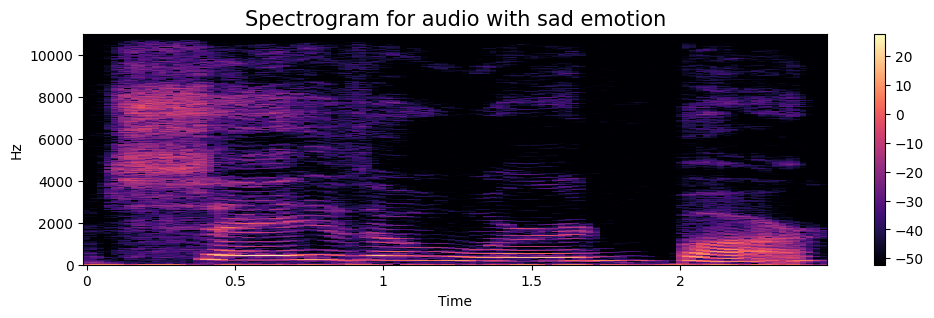

In [12]:
emotion = 'sad'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram (data, sampling_rate, emotion)
Audio(path)

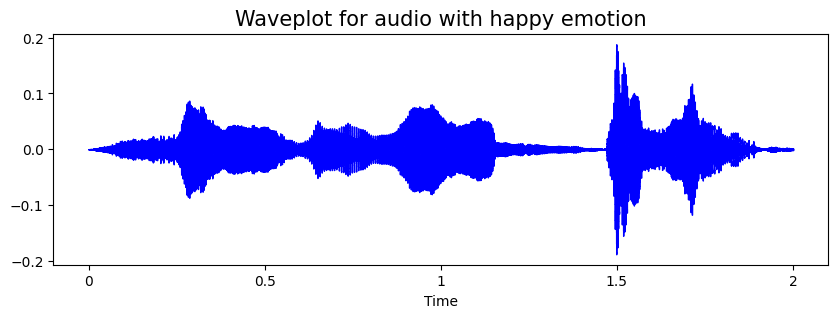

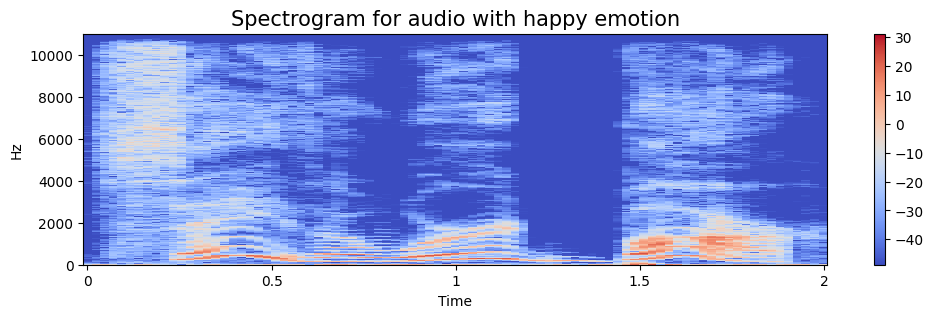

In [13]:
emotion = 'happy'
path= np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)


# # Data Augmentation

In [14]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data+noise_amp*np.random.normal(size = data.shape[0])
    return data

def stretch (data):
    return librosa.effects.time_stretch(data, rate = 0.8)

def shift (data):
    shift_range = int(np.random.uniform(low= -5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch (data, sampling_rate, pitch_factor = 0.7):
    n_steps = int(pitch_factor*12)
    return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = n_steps)


path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)


# 1. Simple Audio

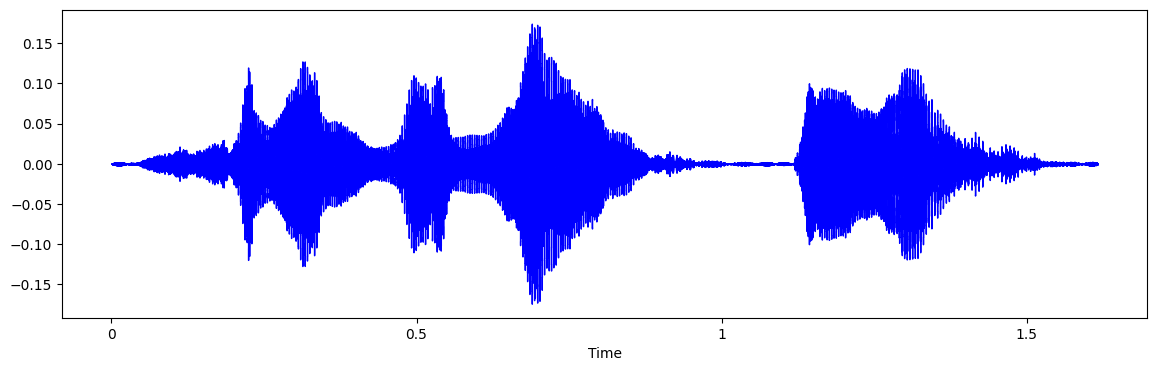

In [15]:
plt.figure(figsize = (14,4))
librosa.display.waveshow(data, sr=sample_rate, color='blue') 
Audio(path)


# 2. Noise Injection

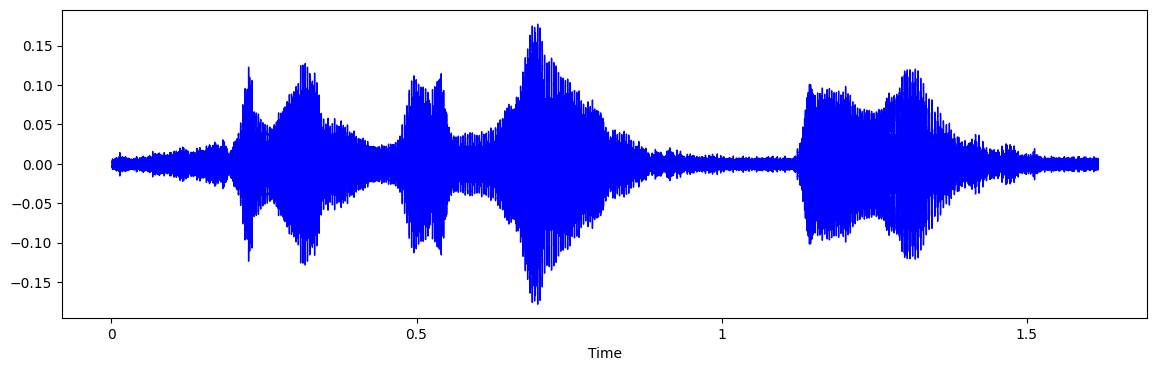

In [16]:
x = noise (data)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y = x, sr = sample_rate, color = 'blue')
Audio(x , rate = sample_rate)


# 3. Stretching

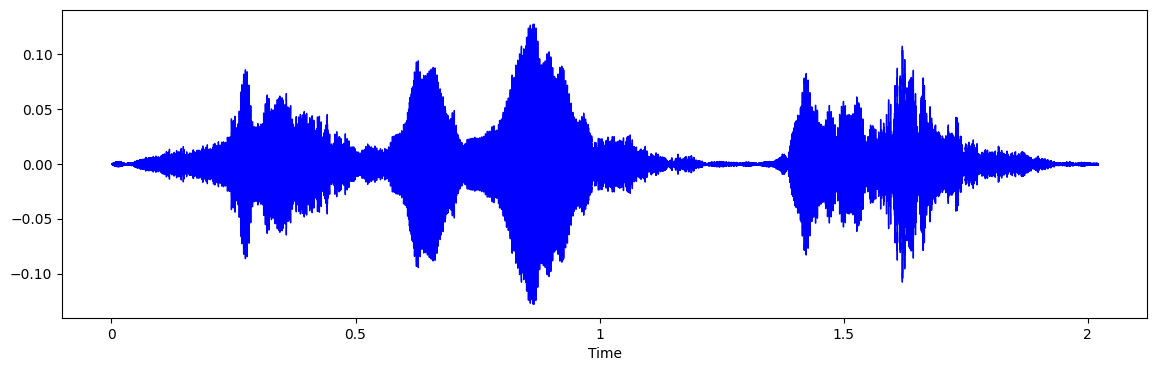

In [17]:
x= stretch(data)
plt.figure(figsize = (14,4))
librosa.display.waveshow(y=x, sr = sample_rate, color = 'blue')
Audio(x, rate = sample_rate)


# 4. Shifting 

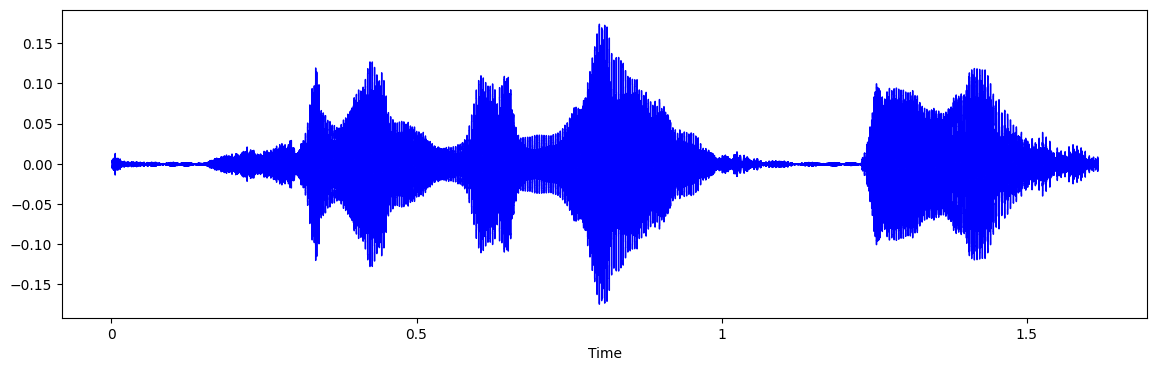

In [18]:
x = shift(data)
plt.figure(figsize = (14,4))
librosa.display.waveshow(y = x, sr = sample_rate, color = 'blue')
Audio(x , rate= sample_rate)


# 5. pitching 

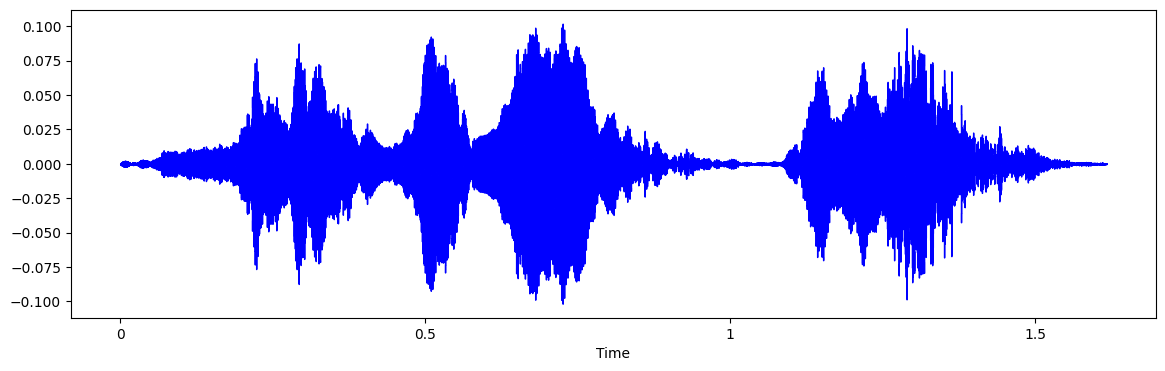

In [19]:
x = pitch(data, sampling_rate)
plt.figure(figsize = (14,4))
librosa.display.waveshow(y =x, sr= sample_rate, color = 'blue')
Audio(x, rate = sample_rate)


# # Feature selection

In [20]:
def extract_features(data):
    #zero crossing rate: The rate of sign-changes of signal during the duration of a particular frame
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y = data).T, axis = 0)
    result = np.hstack((result,zcr)) #stacking horizontally
    
    # #chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.mfcc(y = data, sr = sample_rate).T, axis = 0)
    result = np.hstack((result, chroma_stft))
    
    #MFCCs Mel Frequency Ceptral Coefficients from a Ceptral representation where the frequency bamds are not linear but distributed according to mel-scale
    
    mfcc = np.mean(librosa.feature.mfcc(y = data, sr = sample_rate).T, axis = 0)
    result = np.hstack((result,mfcc))
    
    #Root mean Square Value
    rms= np.mean(librosa.feature.rms(y = data).T, axis = 0)
    result = np.hstack((result , rms))
    
    # MelSpectrogram 
    mel = np.mean(librosa.feature.melspectrogram(y = data, sr = sample_rate).T, axis = 0)
    result = np.hstack((result, mel))
    
    return result

In [21]:
def get_features(path):
    #duration and offset are used to take care of the no audio in the start and the end of each of the audio files seen above.
    data, sample_rate = librosa.load(path, duration = 2.5, offset = 0.6)
    
    #without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    #data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))
    
    #data with stretching and pitching
    new_data = stretch (data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3))
    
    return result

In [36]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)


In [37]:
len (X), len (Y), data_path.Path.shape

(8400, 8400, (2800,))

In [38]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index = False)
Features.head()


# Preparation
# 

,0,1,2,3,4,5,6,7,8,9,...,161,162,163,164,165,166,167,168,169,labels
0,0.054342,-398.608246,75.117401,-21.772625,-19.993965,2.985434,13.788044,-19.953243,-7.025360,-5.187742,...,0.000105,0.000157,0.000185,0.000133,0.000134,0.000070,0.000038,0.000034,6.250596e-06,angry
1,0.107601,-341.691750,55.779124,-17.009570,-19.902118,1.729813,10.193437,-13.902897,-6.221694,-3.377828,...,0.000192,0.000267,0.000274,0.000223,0.000227,0.000161,0.000119,0.000119,1.006405e-04,angry
2,0.109586,-434.843170,46.704422,-51.551666,-5.264840,7.687049,-23.677874,-0.582768,11.519006,0.407528,...,0.000185,0.000301,0.000228,0.000113,0.000121,0.000275,0.000202,0.000091,2.844706e-06,angry
3,0.058006,-469.633392,101.032448,1.475380,-32.444492,-9.686410,14.370925,-1.291309,-5.177820,-9.246143,...,0.000115,0.000082,0.000030,0.000011,0.000015,0.000021,0.000019,0.000015,9.260864e-07,angry
4,0.249645,-263.763424,27.563092,1.406913,-12.430461,-6.793499,0.819697,1.339096,-2.363276,-5.090366,...,0.002613,0.002771,0.002792,0.002702,0.002450,0.002398,0.002606,0.002714,2.733946e-03,angry


In [39]:
X = Features.iloc[:,:-1].values
Y = Features['labels'].values

In [40]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [41]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 170), (6300, 7), (2100, 170), (2100, 7))

In [42]:
scalar = StandardScaler()
x_train = scalar.fit_transform(x_train)
x_test = scalar.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 170), (6300, 7), (2100, 170), (2100, 7))

In [43]:
#data compatible to model
x_train = np.expand_dims(x_train, axis = 2)
x_test = np.expand_dims(x_test, axis = 2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


# Modelling

((6300, 170, 1), (6300, 7), (2100, 170, 1), (2100, 7))

In [44]:
# model = Sequential()
# model.add(Conv1D(256, kernel_size = 5, strides = 1, padding = 'same', activation = 'relu', input_shape = (x_train.shape[1], 1)))
# model.add(MaxPooling1D(pool_size = 5, strides = 2))

# model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

# model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
# model.add(Dropout(0.2))

# model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

# model.add(Flatten())
# model.add(Dense(units = 32, activation = 'relu'))
# model.add(Dropout(0.3))

# model.add(Dense(8, activation = 'softmax'))
# model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


# model.summary()

model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(170,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               264192    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 7)                

In [46]:
# rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
# history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])
history = model.fit(x_train, y_train, validation_split=0.2, epochs=50, batch_size=128)

Epoch 1/50
40/40 [==============================] - 18s 460ms/step - loss: 1.8597 - accuracy: 0.2075 - val_loss: 1.8360 - val_accuracy: 0.2222
Epoch 2/50
32/40 [=======================>......] - ETA: 3s - loss: 1.8659 - accuracy: 0.2090

KeyboardInterrupt: 

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

ValueError: invalid literal for int() with base 10: 'neutral'

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

66/66 [==============================] - 6s 76ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,neutral,neutral
1,happy,surprise
2,neutral,neutral
3,happy,happy
4,surprise,surprise
5,fear,fear
6,fear,fear
7,sad,sad
8,disgust,disgust
9,fear,fear


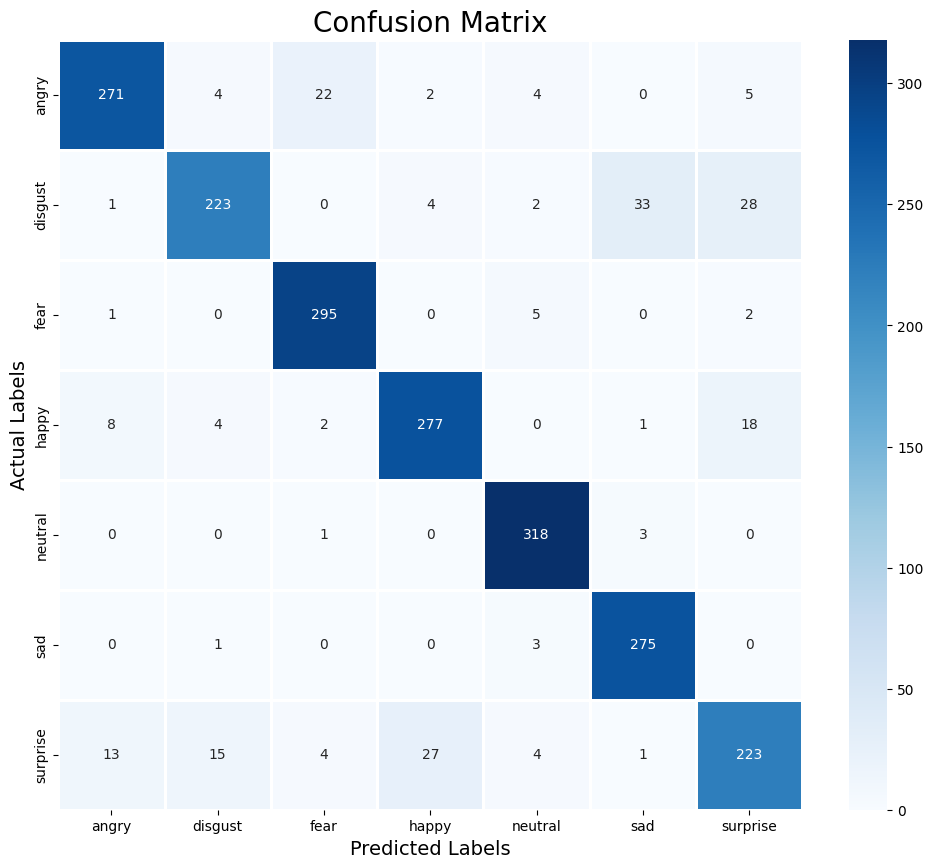

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))
joblib.dump(model, 'your_model.joblib')


# Accuracy of model = 81%

              precision    recall  f1-score   support

       angry       0.92      0.88      0.90       308
     disgust       0.90      0.77      0.83       291
        fear       0.91      0.97      0.94       303
       happy       0.89      0.89      0.89       310
     neutral       0.95      0.99      0.97       322
         sad       0.88      0.99      0.93       279
    surprise       0.81      0.78      0.79       287

    accuracy                           0.90      2100
   macro avg       0.89      0.89      0.89      2100
weighted avg       0.90      0.90      0.89      2100



['your_model.joblib']